In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):
        
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses

In [4]:
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [5]:
class TDRModel(nn.Module):
    """
    Base class for most models. Handles setting most of the member
    variables that are shared for most model definitions.
    """
    def __init__(self, n_units=5, noise=.05, bias=True, gc_bias=None,
                 chans=[8,8], bn_moment=.01, softplus=True,
                 inference_exp=False, img_shape=(40,50,50),
                 ksizes=(15,11,11), recurrent=False, kinetic=False,
                 convgc=False, centers=None, bnorm_d=1,
                 activ_fxn='ReLU', **kwargs):
        """
        Initializes common parameters for retinal models.
        """
        super().__init__()
        self.n_units = n_units
        self.chans = chans
        self.softplus = softplus
        self.infr_exp = inference_exp
        self.bias = bias
        self.img_shape = img_shape
        self.ksizes = ksizes
        self.gc_bias = gc_bias
        self.noise = noise
        self.bn_moment = bn_moment
        self.recurrent = recurrent
        self.kinetic = kinetic
        self.convgc = convgc
        self.centers = centers
        self.bnorm_d = bnorm_d
        assert bnorm_d in [1, 2], "Only 1D and 2D batchnorm are supported."
        self.activ_fxn = activ_fxn

    def forward(self, x):
        """
        This function should be implemented in child classes.
        """
        raise NotImplementedError("Forward function must be implemented in child class.")

    def update_shape(self, shape, kernel_size):
        """
        Helper function to update spatial dimensions after convolution.

        Parameters:
        - shape: tuple (height, width)
        - kernel_size: int or tuple

        Returns:
        - New shape after convolution
        """
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        h_out = shape[0] - kernel_size[0] + 1
        w_out = shape[1] - kernel_size[1] + 1
        return (h_out, w_out)

    def extra_repr(self):
        """
        This function is used in model printing. Shows model parameters.
        """
        s = ['n_units={}', 'noise={}', 'bias={}', 'gc_bias={}',
             'chans={}', 'bn_moment={}', 'softplus={}',
             'inference_exp={}', 'img_shape={}', 'ksizes={}']
        return ", ".join(s).format(self.n_units, self.noise, self.bias,
                                   self.gc_bias, self.chans,
                                   self.bn_moment, self.softplus,
                                   self.infr_exp, self.img_shape, self.ksizes)

    def requires_grad(self, state: bool):
        """
        Enables or disables gradient calculations.

        Parameters:
        - state (bool): True to enable gradients, False to disable.
        """
        for p in self.parameters():
            p.requires_grad = state

In [6]:
# Exact BNCNN Model
class BNCNN(TDRModel):
    """
    BatchNorm CNN for predicting ganglion cell responses.
    """

    def __init__(self, gauss_prior=0, **kwargs):
        super().__init__(**kwargs)
        self.name = 'McNiruNet'
        self.gauss_prior = gauss_prior
        modules = []
        self.shapes = []
        shape = self.img_shape[1:]

        modules.append(nn.Conv2d(self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[0])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(nn.BatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        modules.append(nn.Conv2d(self.chans[0], self.chans[1], kernel_size=self.ksizes[1], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[1])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(nn.BatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2])
            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))

        modules.append(nn.BatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))

        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

        if self.gauss_prior > 0:
            for i, seq_idx in enumerate([0, 6]):
                weight = self.sequential[seq_idx].weight
                filters = []
                for out_i in range(weight.shape[0]):
                    kernels = []
                    for in_i in range(weight.shape[1]):
                        prior_x = signal.gaussian(weight.shape[-1], std=self.gauss_prior)
                        prior_y = signal.gaussian(weight.shape[-2], std=self.gauss_prior)
                        prior = np.outer(prior_y, prior_x)
                        kernels.append(prior)
                    filters.append(np.asarray(kernels))
                prior = np.asarray(filters)
                denom = np.sqrt(weight.shape[0] + weight.shape[1])
                prior = prior / np.max(prior) / denom
                prior = torch.FloatTensor(prior)
                self.sequential[seq_idx].weight.data = prior

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

In [7]:
def train_model(h5_file, hyperparams, batch_size=32, lr=0.001, epochs=100, val_split=0.1):
    dataset = GanglionCellDataset(h5_file)

    # Split dataset into training and validation
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = BNCNN(**hyperparams).to(DEVICE)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir="runs/bncnn_experiment")

    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    all_predictions, all_targets = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_acc, train_count = 0, 0, 0

        for stimuli, firing_rate in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)

            optimizer.zero_grad()
            predictions = model(stimuli)
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            pred_np = predictions.detach().cpu().numpy().flatten()
            target_np = firing_rate.detach().cpu().numpy().flatten()

            if np.std(pred_np) > 0 and np.std(target_np) > 0:
                correlation = np.corrcoef(pred_np, target_np)[0, 1]
            else:
                correlation = 0

            train_acc += correlation
            train_count += 1

            # Store predictions and actual values
            if len(all_predictions) < 10000:
                all_predictions.extend(pred_np)
                all_targets.extend(target_np)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / train_count if train_count > 0 else 0

        loss_history.append(avg_train_loss)
        accuracy_history.append(avg_train_acc)

        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)

        # Validation
        model.eval()
        val_loss, val_acc, val_count = 0, 0, 0
        with torch.no_grad():
            for stimuli, firing_rate in val_loader:
                stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
                predictions = model(stimuli)

                loss = loss_fn(predictions, firing_rate)
                val_loss += loss.item()

                pred_np = predictions.cpu().numpy().flatten()
                target_np = firing_rate.cpu().numpy().flatten()

                if np.std(pred_np) > 0 and np.std(target_np) > 0:
                    correlation = np.corrcoef(pred_np, target_np)[0, 1]
                else:
                    correlation = 0

                val_acc += correlation
                val_count += 1

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / val_count if val_count > 0 else 0

        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_acc)

        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", avg_val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")

    # Save Model
    save_path = "bncnn_model.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    # # Plot Loss Curves
    # plt.figure(figsize=(10, 4))
    # plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', color='b', label='Train Loss')
    # plt.plot(range(1, epochs + 1), val_loss_history, marker='s', linestyle='-', color='r', label='Val Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('MSE Loss')
    # plt.title('Training and Validation Loss Curve')
    # plt.legend()
    # plt.grid()
    # plt.show()

    # Plot Training Loss
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', color='b', label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot Validation Loss
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, epochs + 1), val_loss_history, marker='s', linestyle='-', color='r', label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Validation Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy Curves
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, epochs + 1), accuracy_history, marker='o', linestyle='-', color='g', label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracy_history, marker='s', linestyle='-', color='m', label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Pearson Correlation')
    plt.title('Training and Validation Accuracy Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Predicted vs Real Values
    plt.figure(figsize=(6, 6))
    plt.scatter(all_targets, all_predictions, alpha=0.5, color='r')
    plt.plot([-1, 1], [-1, 1], linestyle='--', color='black')  # Reference line (y=x)
    plt.xlabel('Actual Firing Rate')
    plt.ylabel('Predicted Firing Rate')
    plt.title('Predicted vs Actual Values')
    plt.grid()
    plt.show()

    # Print Final Summary
    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss_history[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracy_history[-1]:.4f}")
    print(f"Size of final prediction array: {len(all_predictions)}")
    print(f"Size of final actual array: {len(all_targets)}")

Epoch 1/100: 100%|██████████| 10120/10120 [04:10<00:00, 40.34it/s]


Epoch 1/100, Train Loss: 101.570722, Train Acc: 0.1601, Val Loss: 101.695248, Val Acc: 0.1922


Epoch 2/100: 100%|██████████| 10120/10120 [03:25<00:00, 49.19it/s]


Epoch 2/100, Train Loss: 99.809207, Train Acc: 0.2039, Val Loss: 101.148494, Val Acc: 0.2062


Epoch 3/100: 100%|██████████| 10120/10120 [13:18<00:00, 12.67it/s]  


Epoch 3/100, Train Loss: 98.193556, Train Acc: 0.2381, Val Loss: 106.583293, Val Acc: 0.2346


Epoch 4/100: 100%|██████████| 10120/10120 [30:52<00:00,  5.46it/s]   


Epoch 4/100, Train Loss: 96.103362, Train Acc: 0.2743, Val Loss: 126.715470, Val Acc: 0.2507


Epoch 5/100: 100%|██████████| 10120/10120 [04:36<00:00, 36.61it/s]


Epoch 5/100, Train Loss: 93.902564, Train Acc: 0.3098, Val Loss: 108.950406, Val Acc: 0.2713


Epoch 6/100: 100%|██████████| 10120/10120 [02:59<00:00, 56.23it/s]


Epoch 6/100, Train Loss: 92.248650, Train Acc: 0.3328, Val Loss: 130.389281, Val Acc: 0.2791


Epoch 7/100: 100%|██████████| 10120/10120 [03:17<00:00, 51.24it/s]


Epoch 7/100, Train Loss: 90.934866, Train Acc: 0.3521, Val Loss: 202.019127, Val Acc: 0.2779


Epoch 8/100: 100%|██████████| 10120/10120 [02:58<00:00, 56.54it/s]


Epoch 8/100, Train Loss: 89.840244, Train Acc: 0.3654, Val Loss: 339.437952, Val Acc: 0.2965


Epoch 9/100: 100%|██████████| 10120/10120 [02:31<00:00, 66.92it/s]


Epoch 9/100, Train Loss: 88.917635, Train Acc: 0.3770, Val Loss: 395.652725, Val Acc: 0.2940


Epoch 10/100: 100%|██████████| 10120/10120 [03:25<00:00, 49.24it/s]


Epoch 10/100, Train Loss: 88.062702, Train Acc: 0.3885, Val Loss: 498.351297, Val Acc: 0.3053


Epoch 11/100: 100%|██████████| 10120/10120 [02:37<00:00, 64.14it/s]


Epoch 11/100, Train Loss: 87.324595, Train Acc: 0.3973, Val Loss: 203.197359, Val Acc: 0.3098


Epoch 12/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.12it/s]


Epoch 12/100, Train Loss: 86.754231, Train Acc: 0.4034, Val Loss: 440.202673, Val Acc: 0.3127


Epoch 13/100: 100%|██████████| 10120/10120 [02:16<00:00, 73.96it/s]


Epoch 13/100, Train Loss: 86.303757, Train Acc: 0.4100, Val Loss: 208.675844, Val Acc: 0.3246


Epoch 14/100: 100%|██████████| 10120/10120 [02:29<00:00, 67.78it/s]


Epoch 14/100, Train Loss: 85.733129, Train Acc: 0.4170, Val Loss: 225.981567, Val Acc: 0.3257


Epoch 15/100: 100%|██████████| 10120/10120 [02:18<00:00, 72.85it/s]


Epoch 15/100, Train Loss: 85.308833, Train Acc: 0.4217, Val Loss: 327.320299, Val Acc: 0.3310


Epoch 16/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.59it/s]


Epoch 16/100, Train Loss: 84.808182, Train Acc: 0.4284, Val Loss: 600.525955, Val Acc: 0.3299


Epoch 17/100: 100%|██████████| 10120/10120 [02:14<00:00, 75.20it/s]


Epoch 17/100, Train Loss: 84.527304, Train Acc: 0.4306, Val Loss: 867.200280, Val Acc: 0.3371


Epoch 18/100: 100%|██████████| 10120/10120 [02:15<00:00, 74.47it/s]


Epoch 18/100, Train Loss: 84.092332, Train Acc: 0.4373, Val Loss: 468.614241, Val Acc: 0.3359


Epoch 19/100: 100%|██████████| 10120/10120 [02:27<00:00, 68.47it/s]


Epoch 19/100, Train Loss: 83.772937, Train Acc: 0.4408, Val Loss: 636.316563, Val Acc: 0.3340


Epoch 20/100: 100%|██████████| 10120/10120 [02:37<00:00, 64.13it/s]


Epoch 20/100, Train Loss: 83.394695, Train Acc: 0.4436, Val Loss: 913.572229, Val Acc: 0.3400


Epoch 21/100: 100%|██████████| 10120/10120 [02:36<00:00, 64.83it/s]


Epoch 21/100, Train Loss: 83.123388, Train Acc: 0.4462, Val Loss: 552.132674, Val Acc: 0.3427


Epoch 22/100: 100%|██████████| 10120/10120 [02:55<00:00, 57.56it/s]


Epoch 22/100, Train Loss: 82.900724, Train Acc: 0.4499, Val Loss: 729.929660, Val Acc: 0.3371


Epoch 23/100: 100%|██████████| 10120/10120 [02:14<00:00, 75.02it/s]


Epoch 23/100, Train Loss: 82.647988, Train Acc: 0.4511, Val Loss: 631.130974, Val Acc: 0.3446


Epoch 24/100: 100%|██████████| 10120/10120 [02:11<00:00, 76.83it/s]


Epoch 24/100, Train Loss: 82.418854, Train Acc: 0.4548, Val Loss: 474.146152, Val Acc: 0.3470


Epoch 25/100: 100%|██████████| 10120/10120 [02:11<00:00, 77.20it/s]


Epoch 25/100, Train Loss: 82.271890, Train Acc: 0.4572, Val Loss: 265.935947, Val Acc: 0.3522


Epoch 26/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.64it/s]


Epoch 26/100, Train Loss: 81.893448, Train Acc: 0.4610, Val Loss: 360.110772, Val Acc: 0.3552


Epoch 27/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.54it/s]


Epoch 27/100, Train Loss: 81.933929, Train Acc: 0.4609, Val Loss: 3662.677087, Val Acc: 0.3366


Epoch 28/100: 100%|██████████| 10120/10120 [02:13<00:00, 75.86it/s]


Epoch 28/100, Train Loss: 81.610706, Train Acc: 0.4646, Val Loss: 707.983651, Val Acc: 0.3551


Epoch 29/100: 100%|██████████| 10120/10120 [02:13<00:00, 75.79it/s]


Epoch 29/100, Train Loss: 81.439774, Train Acc: 0.4672, Val Loss: 1327.577588, Val Acc: 0.3486


Epoch 30/100: 100%|██████████| 10120/10120 [02:11<00:00, 77.19it/s]


Epoch 30/100, Train Loss: 81.165088, Train Acc: 0.4691, Val Loss: 670.197107, Val Acc: 0.3599


Epoch 31/100: 100%|██████████| 10120/10120 [02:10<00:00, 77.75it/s]


Epoch 31/100, Train Loss: 80.984993, Train Acc: 0.4704, Val Loss: 6623.855258, Val Acc: 0.3455


Epoch 32/100: 100%|██████████| 10120/10120 [02:10<00:00, 77.83it/s]


Epoch 32/100, Train Loss: 80.925525, Train Acc: 0.4726, Val Loss: 633.023269, Val Acc: 0.3669


Epoch 33/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.13it/s]


Epoch 33/100, Train Loss: 80.815788, Train Acc: 0.4727, Val Loss: 1233.566477, Val Acc: 0.3628


Epoch 34/100: 100%|██████████| 10120/10120 [02:10<00:00, 77.36it/s]


Epoch 34/100, Train Loss: 80.633324, Train Acc: 0.4751, Val Loss: 1066.917700, Val Acc: 0.3534


Epoch 35/100: 100%|██████████| 10120/10120 [02:11<00:00, 77.21it/s]


Epoch 35/100, Train Loss: 80.526015, Train Acc: 0.4758, Val Loss: 618.642296, Val Acc: 0.3637


Epoch 36/100: 100%|██████████| 10120/10120 [02:10<00:00, 77.70it/s]


Epoch 36/100, Train Loss: 80.323941, Train Acc: 0.4783, Val Loss: 1651.522671, Val Acc: 0.3582


Epoch 37/100: 100%|██████████| 10120/10120 [02:08<00:00, 78.62it/s]


Epoch 37/100, Train Loss: 80.196827, Train Acc: 0.4806, Val Loss: 1063.483848, Val Acc: 0.3626


Epoch 38/100: 100%|██████████| 10120/10120 [02:26<00:00, 69.17it/s]


Epoch 38/100, Train Loss: 80.062996, Train Acc: 0.4814, Val Loss: 4680.207459, Val Acc: 0.3541


Epoch 39/100: 100%|██████████| 10120/10120 [02:16<00:00, 73.93it/s]


Epoch 39/100, Train Loss: 80.110563, Train Acc: 0.4820, Val Loss: 5171.182505, Val Acc: 0.3594


Epoch 40/100: 100%|██████████| 10120/10120 [02:32<00:00, 66.34it/s]


Epoch 40/100, Train Loss: 79.888297, Train Acc: 0.4827, Val Loss: 398.183693, Val Acc: 0.3680


Epoch 41/100: 100%|██████████| 10120/10120 [03:07<00:00, 54.08it/s]


Epoch 41/100, Train Loss: 79.735445, Train Acc: 0.4850, Val Loss: 291.200448, Val Acc: 0.3746


Epoch 42/100: 100%|██████████| 10120/10120 [02:15<00:00, 74.51it/s]


Epoch 42/100, Train Loss: 79.738847, Train Acc: 0.4861, Val Loss: 657.489614, Val Acc: 0.3662


Epoch 43/100: 100%|██████████| 10120/10120 [02:12<00:00, 76.51it/s]


Epoch 43/100, Train Loss: 79.704820, Train Acc: 0.4862, Val Loss: 664.086720, Val Acc: 0.3740


Epoch 44/100: 100%|██████████| 10120/10120 [02:13<00:00, 75.97it/s]


Epoch 44/100, Train Loss: 79.492730, Train Acc: 0.4883, Val Loss: 3270.488048, Val Acc: 0.3667


Epoch 45/100: 100%|██████████| 10120/10120 [02:09<00:00, 77.86it/s]


Epoch 45/100, Train Loss: 79.415202, Train Acc: 0.4888, Val Loss: 1182.070307, Val Acc: 0.3629


Epoch 46/100: 100%|██████████| 10120/10120 [02:10<00:00, 77.32it/s]


Epoch 46/100, Train Loss: 79.398215, Train Acc: 0.4900, Val Loss: 4026.451163, Val Acc: 0.3716


Epoch 47/100: 100%|██████████| 10120/10120 [02:33<00:00, 65.90it/s]


Epoch 47/100, Train Loss: 79.257874, Train Acc: 0.4902, Val Loss: 1472.846743, Val Acc: 0.3765


Epoch 48/100: 100%|██████████| 10120/10120 [02:18<00:00, 72.86it/s]


Epoch 48/100, Train Loss: 79.155827, Train Acc: 0.4920, Val Loss: 541.566689, Val Acc: 0.3755


Epoch 49/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.16it/s]


Epoch 49/100, Train Loss: 79.117035, Train Acc: 0.4931, Val Loss: 620.396452, Val Acc: 0.3708


Epoch 50/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.24it/s]


Epoch 50/100, Train Loss: 79.025924, Train Acc: 0.4927, Val Loss: 523.067725, Val Acc: 0.3797


Epoch 51/100: 100%|██████████| 10120/10120 [02:18<00:00, 73.03it/s]


Epoch 51/100, Train Loss: 78.985405, Train Acc: 0.4939, Val Loss: 3865.380273, Val Acc: 0.3641


Epoch 52/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.47it/s]


Epoch 52/100, Train Loss: 78.806321, Train Acc: 0.4949, Val Loss: 12726.911120, Val Acc: 0.3730


Epoch 53/100: 100%|██████████| 10120/10120 [02:11<00:00, 76.95it/s]


Epoch 53/100, Train Loss: 78.702099, Train Acc: 0.4975, Val Loss: 1766.651211, Val Acc: 0.3772


Epoch 54/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.27it/s]


Epoch 54/100, Train Loss: 78.558451, Train Acc: 0.4979, Val Loss: 2913.016761, Val Acc: 0.3780


Epoch 55/100: 100%|██████████| 10120/10120 [02:11<00:00, 77.03it/s]


Epoch 55/100, Train Loss: 78.661932, Train Acc: 0.4965, Val Loss: 693.400286, Val Acc: 0.3826


Epoch 56/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.37it/s]


Epoch 56/100, Train Loss: 78.599263, Train Acc: 0.4985, Val Loss: 397.741461, Val Acc: 0.3829


Epoch 57/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.27it/s]


Epoch 57/100, Train Loss: 78.313727, Train Acc: 0.5006, Val Loss: 435.012282, Val Acc: 0.3801


Epoch 58/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.12it/s]


Epoch 58/100, Train Loss: 78.482483, Train Acc: 0.5002, Val Loss: 305.106006, Val Acc: 0.3842


Epoch 59/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.24it/s]


Epoch 59/100, Train Loss: 78.334861, Train Acc: 0.5003, Val Loss: 320.285772, Val Acc: 0.3813


Epoch 60/100: 100%|██████████| 10120/10120 [02:10<00:00, 77.39it/s]


Epoch 60/100, Train Loss: 78.298624, Train Acc: 0.5016, Val Loss: 510.583700, Val Acc: 0.3854


Epoch 61/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.00it/s]


Epoch 61/100, Train Loss: 78.197636, Train Acc: 0.5011, Val Loss: 329.983271, Val Acc: 0.3830


Epoch 62/100: 100%|██████████| 10120/10120 [02:08<00:00, 78.60it/s]


Epoch 62/100, Train Loss: 78.057923, Train Acc: 0.5034, Val Loss: 986.073665, Val Acc: 0.3843


Epoch 63/100: 100%|██████████| 10120/10120 [02:14<00:00, 75.36it/s]


Epoch 63/100, Train Loss: 78.095981, Train Acc: 0.5028, Val Loss: 851.881383, Val Acc: 0.3809


Epoch 64/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.36it/s]


Epoch 64/100, Train Loss: 77.967735, Train Acc: 0.5046, Val Loss: 551.049980, Val Acc: 0.3839


Epoch 65/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.76it/s]


Epoch 65/100, Train Loss: 78.030416, Train Acc: 0.5049, Val Loss: 591.164376, Val Acc: 0.3801


Epoch 66/100: 100%|██████████| 10120/10120 [02:13<00:00, 75.55it/s]


Epoch 66/100, Train Loss: 77.995780, Train Acc: 0.5043, Val Loss: 1502.969630, Val Acc: 0.3855


Epoch 67/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.23it/s]


Epoch 67/100, Train Loss: 77.897268, Train Acc: 0.5056, Val Loss: 3096.561483, Val Acc: 0.3708


Epoch 68/100: 100%|██████████| 10120/10120 [02:10<00:00, 77.58it/s]


Epoch 68/100, Train Loss: 77.765276, Train Acc: 0.5066, Val Loss: 627.266008, Val Acc: 0.3822


Epoch 69/100: 100%|██████████| 10120/10120 [02:17<00:00, 73.34it/s]


Epoch 69/100, Train Loss: 77.789200, Train Acc: 0.5066, Val Loss: 1380.268952, Val Acc: 0.3874


Epoch 70/100: 100%|██████████| 10120/10120 [02:43<00:00, 61.73it/s]


Epoch 70/100, Train Loss: 77.818219, Train Acc: 0.5075, Val Loss: 814.472418, Val Acc: 0.3854


Epoch 71/100: 100%|██████████| 10120/10120 [02:48<00:00, 59.90it/s]


Epoch 71/100, Train Loss: 77.677094, Train Acc: 0.5079, Val Loss: 1706.945111, Val Acc: 0.3900


Epoch 72/100: 100%|██████████| 10120/10120 [03:07<00:00, 54.11it/s]


Epoch 72/100, Train Loss: 77.636213, Train Acc: 0.5078, Val Loss: 2246.794014, Val Acc: 0.3833


Epoch 73/100: 100%|██████████| 10120/10120 [02:44<00:00, 61.43it/s]


Epoch 73/100, Train Loss: 77.607614, Train Acc: 0.5086, Val Loss: 4500.386723, Val Acc: 0.3778


Epoch 74/100: 100%|██████████| 10120/10120 [02:39<00:00, 63.27it/s]


Epoch 74/100, Train Loss: 77.442296, Train Acc: 0.5102, Val Loss: 445.153062, Val Acc: 0.3910


Epoch 75/100: 100%|██████████| 10120/10120 [02:52<00:00, 58.75it/s]


Epoch 75/100, Train Loss: 77.469697, Train Acc: 0.5098, Val Loss: 343.682845, Val Acc: 0.3971


Epoch 76/100: 100%|██████████| 10120/10120 [03:03<00:00, 55.30it/s]


Epoch 76/100, Train Loss: 77.240211, Train Acc: 0.5100, Val Loss: 8360.237341, Val Acc: 0.3856


Epoch 77/100: 100%|██████████| 10120/10120 [02:41<00:00, 62.55it/s]


Epoch 77/100, Train Loss: 77.338472, Train Acc: 0.5112, Val Loss: 1263.224392, Val Acc: 0.3850


Epoch 78/100: 100%|██████████| 10120/10120 [02:40<00:00, 63.15it/s]


Epoch 78/100, Train Loss: 77.329552, Train Acc: 0.5121, Val Loss: 849.143101, Val Acc: 0.3915


Epoch 79/100: 100%|██████████| 10120/10120 [02:36<00:00, 64.52it/s]


Epoch 79/100, Train Loss: 77.196865, Train Acc: 0.5121, Val Loss: 580.460854, Val Acc: 0.3911


Epoch 80/100: 100%|██████████| 10120/10120 [02:47<00:00, 60.51it/s]


Epoch 80/100, Train Loss: 77.181444, Train Acc: 0.5124, Val Loss: 393.840418, Val Acc: 0.3976


Epoch 81/100: 100%|██████████| 10120/10120 [02:53<00:00, 58.25it/s]


Epoch 81/100, Train Loss: 77.117715, Train Acc: 0.5125, Val Loss: 635.488980, Val Acc: 0.3934


Epoch 82/100: 100%|██████████| 10120/10120 [02:38<00:00, 63.76it/s]


Epoch 82/100, Train Loss: 77.213035, Train Acc: 0.5134, Val Loss: 523.450537, Val Acc: 0.3979


Epoch 83/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.57it/s]


Epoch 83/100, Train Loss: 77.079350, Train Acc: 0.5140, Val Loss: 1190.528712, Val Acc: 0.3956


Epoch 84/100: 100%|██████████| 10120/10120 [02:14<00:00, 75.34it/s]


Epoch 84/100, Train Loss: 77.048700, Train Acc: 0.5139, Val Loss: 559.600728, Val Acc: 0.3889


Epoch 85/100: 100%|██████████| 10120/10120 [02:11<00:00, 77.13it/s]


Epoch 85/100, Train Loss: 77.020154, Train Acc: 0.5140, Val Loss: 2082.283641, Val Acc: 0.3885


Epoch 86/100: 100%|██████████| 10120/10120 [02:11<00:00, 76.69it/s]


Epoch 86/100, Train Loss: 76.947245, Train Acc: 0.5148, Val Loss: 1831.332552, Val Acc: 0.3954


Epoch 87/100: 100%|██████████| 10120/10120 [02:12<00:00, 76.60it/s]


Epoch 87/100, Train Loss: 76.870434, Train Acc: 0.5150, Val Loss: 4693.415442, Val Acc: 0.3916


Epoch 88/100: 100%|██████████| 10120/10120 [02:14<00:00, 75.09it/s]


Epoch 88/100, Train Loss: 76.759752, Train Acc: 0.5163, Val Loss: 1391.465115, Val Acc: 0.3885


Epoch 89/100: 100%|██████████| 10120/10120 [02:18<00:00, 73.01it/s]


Epoch 89/100, Train Loss: 76.818830, Train Acc: 0.5159, Val Loss: 1144.488746, Val Acc: 0.3981


Epoch 90/100: 100%|██████████| 10120/10120 [02:10<00:00, 77.67it/s]


Epoch 90/100, Train Loss: 76.829595, Train Acc: 0.5170, Val Loss: 1483.646958, Val Acc: 0.3916


Epoch 91/100: 100%|██████████| 10120/10120 [02:09<00:00, 77.88it/s]


Epoch 91/100, Train Loss: 76.826776, Train Acc: 0.5152, Val Loss: 3086.536036, Val Acc: 0.3930


Epoch 92/100: 100%|██████████| 10120/10120 [02:08<00:00, 78.57it/s]


Epoch 92/100, Train Loss: 76.785343, Train Acc: 0.5167, Val Loss: 2797.548172, Val Acc: 0.3905


Epoch 93/100: 100%|██████████| 10120/10120 [02:08<00:00, 78.65it/s]


Epoch 93/100, Train Loss: 76.671318, Train Acc: 0.5194, Val Loss: 1437.483850, Val Acc: 0.3918


Epoch 94/100: 100%|██████████| 10120/10120 [02:08<00:00, 78.87it/s]


Epoch 94/100, Train Loss: 76.666178, Train Acc: 0.5173, Val Loss: 7895.488167, Val Acc: 0.3885


Epoch 95/100: 100%|██████████| 10120/10120 [02:26<00:00, 69.04it/s]


Epoch 95/100, Train Loss: 76.697103, Train Acc: 0.5180, Val Loss: 45706.064723, Val Acc: 0.3829


Epoch 96/100: 100%|██████████| 10120/10120 [02:16<00:00, 74.05it/s]


Epoch 96/100, Train Loss: 76.629331, Train Acc: 0.5180, Val Loss: 936.552066, Val Acc: 0.4000


Epoch 97/100: 100%|██████████| 10120/10120 [02:08<00:00, 78.63it/s]


Epoch 97/100, Train Loss: 76.565726, Train Acc: 0.5186, Val Loss: 2262.432683, Val Acc: 0.3947


Epoch 98/100: 100%|██████████| 10120/10120 [02:08<00:00, 78.53it/s]


Epoch 98/100, Train Loss: 76.481091, Train Acc: 0.5200, Val Loss: 1256.388798, Val Acc: 0.4009


Epoch 99/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.53it/s]


Epoch 99/100, Train Loss: 76.477824, Train Acc: 0.5197, Val Loss: 537.151138, Val Acc: 0.3981


Epoch 100/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.50it/s]


Epoch 100/100, Train Loss: 76.517487, Train Acc: 0.5206, Val Loss: 3458.305401, Val Acc: 0.3976
Model saved to bncnn_model.pth


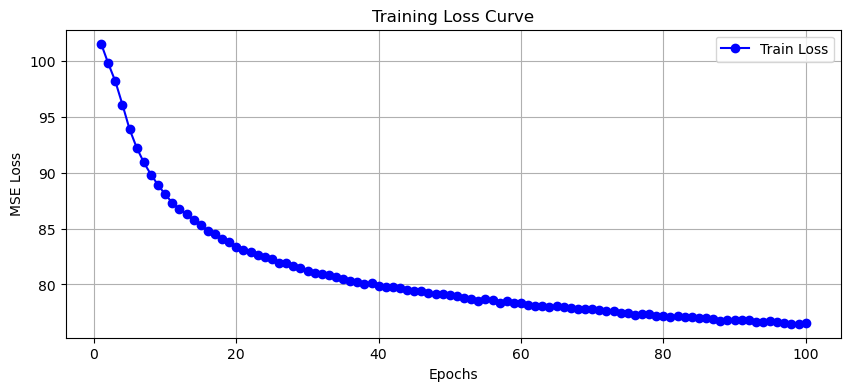

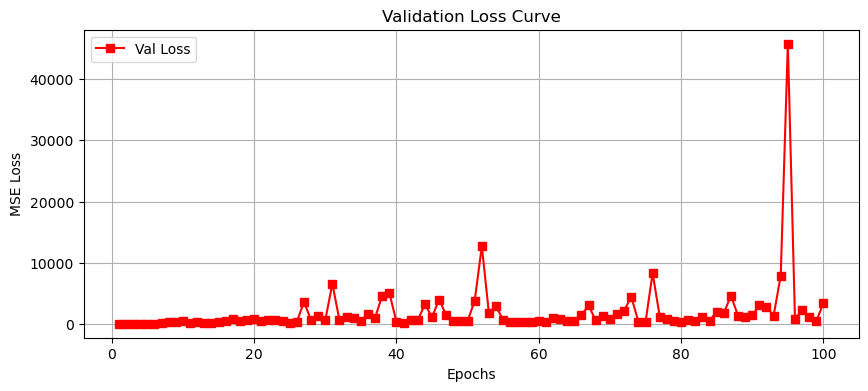

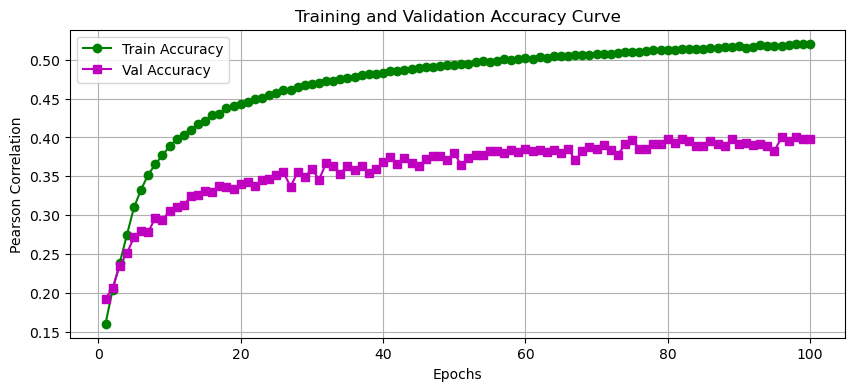

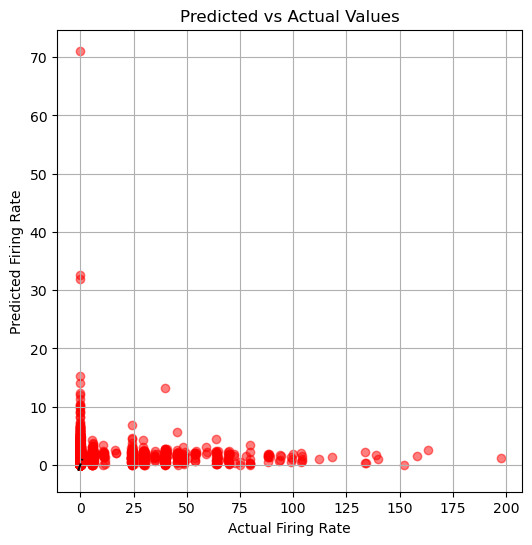

Final Training Loss: 76.517487
Final Training Accuracy: 0.5206
Final Validation Loss: 3458.305401
Final Validation Accuracy: 0.3976
Size of final prediction array: 10080
Size of final actual array: 10080


In [8]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [32, 64],
    'ksizes': [5, 5, 3],
    'bias': False,
    'bnorm_d': 2,
    'bn_moment': 0.1,
    'noise': 0.1,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': False,
    'convgc': False,
    'centers': None
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
train_model(h5_path, hyperparams)